## DSCI 100 Project Proposal Team 44

Melanie Law, 98162993

# Project Title: Determining The Best Predictors Heart Disease

## Introduction

*See appendix for dataset  abbreviations

## Preliminary Data Analysis

In [39]:
#install.packages("corrplot")

In [40]:
#Loading relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(corrplot)

In [41]:
#Loading and formatting the data

data <- read_delim("processed.cleveland.data", delim =",", col_names = FALSE)

attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

head(data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [42]:
#Determining if the data has NA values
na_count <-sapply(data, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count #no missing values were found upon initial inspection 

,na_count
,<int>
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0


In [43]:
#Note: the columns ca and thal load as character types as they contain non-numeric values.
#R does this as default to preserve information. Convert to numeric types then filter to remove NA values 

data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))

head(data)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [44]:
# Split dataset into training/testing --------------------------------------

heart_split <- initial_split(data, prop = 0.8, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train_explore <- heart_train %>% 
  mutate(disease = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(sex_char = ifelse(sex == 1 ,"male","female")) %>% 
  mutate(num_b = ifelse(num > 0, 1, 0)) #binarizes the heart disease status as either present (1) or absent (0)

In [45]:
# Exploratory Tables ------------------------------------------------------
heart_proportions <- heart_train %>% 
  group_by(num) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train))%>%
  rename("disease" = num,
         "count" = n)
heart_proportions

heart_proportions_2 <- heart_train_explore %>% 
  group_by(disease) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train_explore))%>%
  rename("status" = disease,
         "count" = n)
heart_proportions_2

summary <- heart_train %>%
  pivot_longer(everything()) %>%
  arrange(name) %>%
  group_by(name) %>%
  summarize(
    mean = mean(value),
    std_dev = sd(value),
    median = median(value),
    max = max(value),
    min = min(value),
    quartile.1 = quantile(value, 0.25),
    quartile.3 = quantile(value, 0.75)) %>%
  rename("predictor" = name)
summary

#Correlation matrix
cor_hr <- heart_train_explore %>% 
  select(-c(sex_char, disease)) %>% 
  cor()
round(cor_hr,2)

num_char <- heart_train_explore %>% 
  select(disease, num, sex, sex_char, age) %>% 
  group_by(num, sex_char) %>% 
  summarise(n = n())

#Export dataframes
# write.table(summary, file = "heart_summary_stats.csv", row.names = FALSE)
# write.table(heart_proportions, file = "strata_num.csv",row.names = FALSE)
# write.table(heart_proportions_2, file = "strata_num_consolidated.csv",row.names = FALSE)

`summarise()` ungrouping output (override with `.groups` argument)



disease,count,percent
<dbl>,<int>,<dbl>
0,129,53.750000
1,44,18.333333
2,28,11.666667
3,28,11.666667
4,11,4.583333


`summarise()` ungrouping output (override with `.groups` argument)



status,count,percent
<chr>,<int>,<dbl>
disease,111,46.25
healthy,129,53.75


`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,std_dev,median,max,min,quartile.1,quartile.3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,54.4416667,9.1109349,56.0,77.0,29,47.0,61.00
ca,0.6833333,0.9327454,0.0,3.0,0,0.0,1.00
chol,247.6250000,53.9693176,242.5,564.0,126,210.5,276.25
cp,3.1458333,0.9764932,3.0,4.0,1,2.0,4.00
exang,0.3250000,0.4693537,0.0,1.0,0,0.0,1.00
fbs,0.1458333,0.3536766,0.0,1.0,0,0.0,0.00
num,0.9500000,1.2398542,0.0,4.0,0,0.0,2.00
oldpeak,1.0508333,1.1697724,0.7,6.2,0,0.0,1.80
restecg,0.9791667,0.9955882,0.0,2.0,0,0.0,2.00


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_b
age,1.00,-0.10,0.10,0.29,0.22,0.15,0.19,-0.38,0.11,0.17,0.13,0.46,0.09,0.25,0.26
sex,-0.10,1.00,-0.01,-0.03,-0.18,0.05,0.01,-0.05,0.12,0.08,0.01,0.06,0.38,0.20,0.26
cp,0.10,-0.01,1.00,-0.04,0.05,-0.06,0.12,-0.31,0.37,0.19,0.11,0.25,0.27,0.38,0.38
trestbps,0.29,-0.03,-0.04,1.00,0.10,0.20,0.14,-0.07,0.08,0.22,0.16,0.14,0.13,0.18,0.20
chol,0.22,-0.18,0.05,0.10,1.00,-0.01,0.20,-0.02,0.04,0.06,0.00,0.14,0.00,0.08,0.09
fbs,0.15,0.05,-0.06,0.20,-0.01,1.00,0.09,-0.05,0.02,0.04,0.08,0.15,0.11,0.07,0.02
restecg,0.19,0.01,0.12,0.14,0.20,0.09,1.00,-0.07,0.05,0.15,0.15,0.16,0.03,0.25,0.20
thalach,-0.38,-0.05,-0.31,-0.07,-0.02,-0.05,-0.07,1.00,-0.40,-0.34,-0.35,-0.34,-0.28,-0.42,-0.42
exang,0.11,0.12,0.37,0.08,0.04,0.02,0.05,-0.40,1.00,0.26,0.19,0.19,0.34,0.39,0.44
oldpeak,0.17,0.08,0.19,0.22,0.06,0.04,0.15,-0.34,0.26,1.00,0.58,0.37,0.35,0.55,0.45


`summarise()` regrouping output by 'num' (override with `.groups` argument)



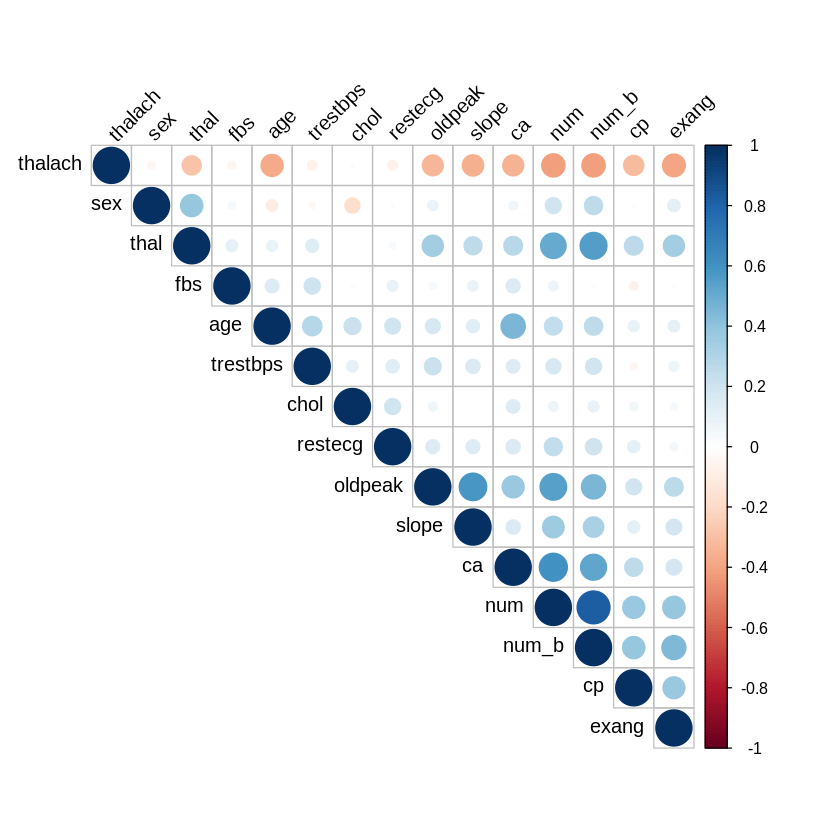

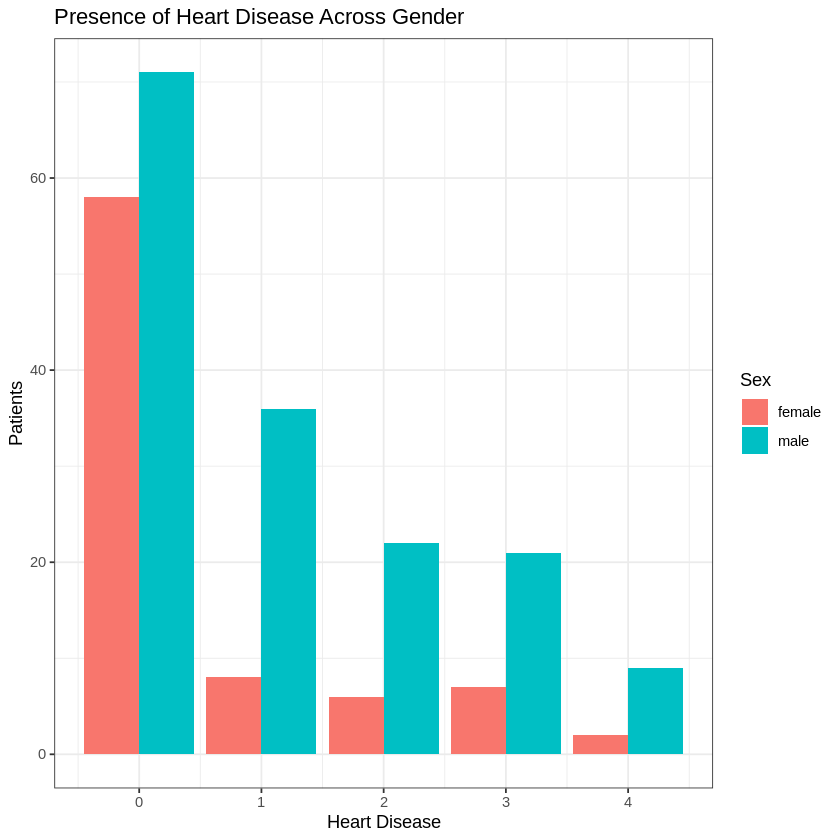

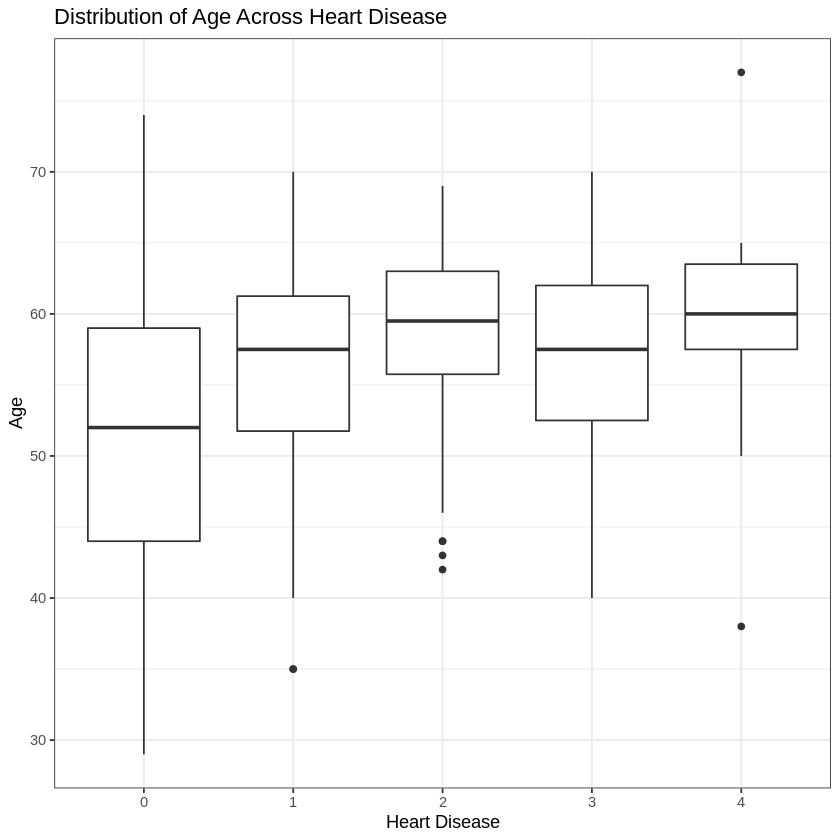

In [48]:
# Visualizations ----------------------------------------------------------
#Correlation matrix plot
corrplot(cor_hr, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

#Grouped barchart for sex vs heart disease
sex_bar_plot <- num_char %>% 
  ggplot(aes(x = num, y = n, fill = sex_char))+
  geom_bar(position="dodge", stat="identity")+
  labs(x = "Heart Disease", y = "Patients", fill = "Sex")+
  theme_bw()+
  ggtitle("Presence of Heart Disease Across Gender")
sex_bar_plot

#age box plot
age_box_plot <- heart_train_explore %>% 
  ggplot(aes(x= as.factor(num), y = age))+
  geom_boxplot()+
  labs(x = "Heart Disease", y = "Age")+
  theme_bw()+
  ggtitle("Distribution of Age Across Heart Disease")
age_box_plot

### Preliminary Analysis Takeaways
- Looking only at numeric predictors, these predictors appear to have weak correlation with each other and are thus likely independent. Hence there are likely no confounding variables in the data.
- In comparing the incidence of heart disease between genders, there is a sex bias where there is a higher incidence of heart disease in males than females. As much it may be more appropriate to stratify the data by gender first as men and women do not have the same disease burden.
- There does not appear to be an age bias between individuals with and without heart disease. Hence stratifying by age may not be necessary. Because the majority of data point fall between the ages of 45 to 65 years, it is possible that the resulting classifier may be more accurate at predicting heart disease in this age range rather than in younger or older demographics.

## Methods

## Expected Outome and Significance

### Expectations
This heart disease classifier is used to diagnose whether a person has heart disease or not. Based on the preliminary exploratory data analysis above, we expect to find that not all of the original predictors are required to create the most accurate classifier.  As shown through the correlation matrix and accompanying plot, some attritbutes do not appear to have a strong correlation with heart disease. Furthermore,  restecg, fbs, thalach, and cp may also be included as some of the best predictors of heart disease. Based on literature, if a person experiences abnormal resting ECG results with ST-T waves or probable or definite left ventricular hypertrophy according to Estes criteria, or fasting blood sugar, or chest pain, or maximum heart rate achieved, the chance of risk of having heart disease is increased.

### Implications
The findings could help practitioners  diagnose heart disease more accurately by only considering relevant predictor metrics. This classifier could also be used to preform a preliminary screen to identify those who are likely to have heart disease and require a more extensive follow up for an official diagnosis. Furthermore, by indentifiying what metrics are relevant to the prognosis of heart disease, the metrics could also tracked to monitor patient progression and response to treatment.

### Future Questions 
Since only the Cleveland dataset was used to train the classifier, it is possible that only considering this data set may have introduced a geographical bias. As such, a future direction could be to analyze the accuracy of the classifier in predicting heart disease for other areas and datasets. Another future question could be to indentify ranges of the found relevant predictors in which patients could be classified into different risk groups for the likehihood of developing heart disease. 

## References

Heart Disease Data Set. (1988, July 1). UCI Machine Learning Repository. Retrieved   March 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Appendix

| Abbreviation      | Description |
| ----------- | ----------- |
| age         | age       |
| sex         | sex         |
| cp          | chest pain |
| trestbps    | resting blood pressure |
| chol        | cholesterol |
| fbs         | fasting blood sugar |
| restecg     | resting electrocardiographic results |
| thalach     | maximum heart rate record |
| exang       | exercise induced angia |
| oldpeak     | ST depression indiced by exercise relative to rest |
| slope       | slope of peak exercise ST segment |
| ca          | number of major vessicles coloured by fluoroscopy |
| thal        | thalassemia |
| num         | predicted attribute |



